In [1]:
import torch
import torch.nn as nn
import gym

from seagul.nn import Categorical_MLP, MLP, DummyNet, fit_model

# TODO maybe import algos into rl __init__
from seagul.rl.ppo_switching import ppo_switch
from seagul.rl.ppo import ppo

from tqdm import trange
from numpy import pi
import numpy as np

import matplotlib.pyplot as plt

torch.set_default_dtype(torch.double)

policy = MLP(input_size=4, output_size=1, layer_size=12, num_layers=2, activation=nn.ReLU)
value_fn = MLP(input_size=4, output_size=1, layer_size=12, num_layers=2, activation=nn.ReLU)
gate_fn = Categorical_MLP(input_size=4, output_size=1, layer_size=12, num_layers=2, activation=nn.ReLU)

/Users/sgillen/.local/lib/python3.6/site-packages/gym/envs/registration.py:64: UserWarning: register(timestep_limit=1000) is deprecated. Use register(max_episode_steps=1000) instead.
  warnings.warn("register(timestep_limit={}) is deprecated. Use register(max_episode_steps={}) instead.".format(timestep_limit, timestep_limit))


In [ ]:
# Generate data for the supervised learning task
env = gym.make('su_cartpole-v0')
num_points = int(2e4)

X = torch.zeros(num_points, env.observation_space.shape[0])  
Y = torch.zeros(num_points,1)

for i in trange(num_points):
        
        point = env.observation_space.sample()
        X[i] = torch.as_tensor(point)
        
        if (point[0] > 145 * pi / 180) and (point[0] < 215 * pi / 180):
            Y[i] = 1
        else:
            Y[i] = 0
            

In [ ]:
# fit our gating network to the data we generated above

hist = fit_model(gate_fn,X,Y,50)
plt.plot(hist)

In [ ]:
# evauluate how well our classifier is doing now

env = gym.make('su_cartpole-v0')
num_points = int(2e4)

pred_Y = torch.zeros(num_points,1)
pred_X = np.zeros((num_points,1))
up_wrong = 0; up_right = 0; down_wrong = 0; down_right = 0;
for i in trange(num_points):
        
        point = env.observation_space.sample()
        y = gate_fn(torch.as_tensor(point,dtype=torch.float64))
        
        if (point[0] > 145 * pi / 180) and (point[0] < 215 * pi / 180):
            if y < .5:
                #print("wrong!" , c)
                up_wrong +=1
            else:
                up_right +=1
        else:
            if y > .5:
                #print("wrong again!" , c)
                down_wrong +=1
            else:
                down_right +=1
       
print("balancing controller misclassified: " , up_wrong)
print("balancing controller corectly classified: " , up_right)
print("balancing controller accuracy: " , up_right/(up_right+up_wrong))

     
print("swingup controller misclassified: " , down_wrong)
print("swingup controller corectly classified: " , down_right)
print("balancing controller accuracy: " , down_right/(down_right+down_wrong))


100%|██████████| 500/500 [12:11<00:00,  2.11s/it]

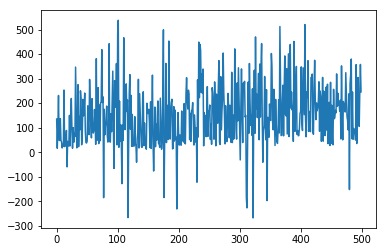

In [16]:
t_policy, t_val, rewards, var_dict = ppo('su_cartpole_push-v0', 50, policy, value_fn, action_var = 4)
#t_policy, t_val, t_gate, rewards, var_dict = ppo_switch(
#    "su_cartpole_push-v0", 500, policy, value_fn, gate_fn, epoch_batch_size=50, reward_stop=1400
#)

plt.plot(rewards)

In [4]:
var_dict.keys()

dict_keys(['run_time', 'end_time', 'v_loss', 'local_values', 'p_loss', 'r', 'old_logp', 'logp', 'local_adv', 'local_actions', 'local_states', 'training_generator', 'training_data', 'ep_adv', 'deltas', 'value_preds', 'ep_disc_rewards', 'ep_action_tensor', 'ep_state_tensor', '_', 'done', 'reward', 'state_np', 'logprob', 'action', 't', 'reward_list', 'state_list', 'action_list', 'state', 'action_tensor', 'state_tensor', 'disc_rewards_tensor', 'adv_tensor', 'traj_count', 'traj_steps', 'batch_steps', 'episode_reward_sum', 'epoch', 'avg_reward_hist', 'device', 'use_cuda', 'v_optimizer', 'p_optimizer', 'old_policy', 'action_size', 'get_logp', 'select_action', 'env', 'start_time', 'reward_stop', 'use_gpu', 'v_epochs', 'p_epochs', 'value_lr', 'policy_lr', 'value_batch_size', 'policy_batch_size', 'seed', 'eps', 'lam', 'gamma', 'epoch_batch_size', 'value_fn', 'policy', 'num_epochs', 'env_name'])

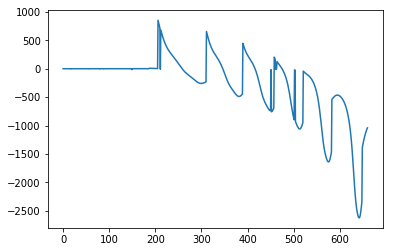

In [17]:
plt.plot(var_dict['action_list'])

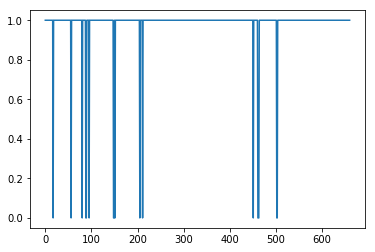

In [18]:
plt.plot(var_dict['path_list'])

array([[   1.15722568,  -50.04812718,  -15.03012867, -132.56324521],
       [   1.15722568,  -50.04812718,  -15.03012867, -132.56324521],
       [   1.15722568,  -50.04812718,  -15.03012867, -132.56324521],
       ...,
       [   1.03888088,  -50.40690405,   -8.41783394, -128.9654165 ],
       [   1.03888088,  -50.40690405,   -8.41783394, -128.9654165 ],
       [   1.03888088,  -50.40690405,   -8.41783394, -128.9654165 ]])

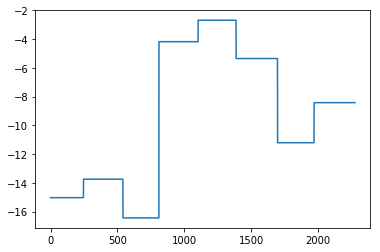

In [14]:
plt.plot(np.array(var_dict['state_tensor'])[:,2])
np.array(var_dict['state_tensor'])

In [12]:
var_dict['action_tensor']

tensor([[  3.1520],
        [ -1.3469],
        [ -3.8641],
        ...,
        [-17.2056],
        [-16.1530],
        [-15.6348]])